In [28]:
import time; import random; import datetime
import warnings
warnings.filterwarnings("ignore")


import os
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt


%matplotlib inline

import contextlib
import wave 

import scipy

import librosa
import librosa.display
from glob import glob
from scipy.io import wavfile

from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.signal import find_peaks 


import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, AveragePooling2D, ReLU, MaxPool2D

)

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model

import cv2

In [25]:
def moving_average(a, n=100):
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret = ret[n - 1:] / n
    zero_arr = [0]*(n-1)
    return np.append(zero_arr, ret)

In [26]:
def cutting_wave(readfile, writefile):
    sig, sr = librosa.load(readfile, sr=16000)
    
    fp = find_peaks(list(sig), height=0.2)[0] #높이가 최소 0.2 이상인 값을 찾음

    fp_diff = np.diff(fp)>3000 #다음 기침은 최소 0.2초 이후에 한다 가정
    fp_diff = np.append(fp_diff, False) #차분 값의 마지막에 False 값 추가
    if sum(fp_diff)==0: fp_index = 0
    else: fp_index = list(fp[fp_diff]) #True인 값 추출 (차이가 커지기 전 인덱스 추출)
    
    #한주기
    if fp_index==0:
        yt,idx = librosa.effects.trim(sig, top_db = 10)
        
        mv = moving_average(yt, 10)

        if sum(mv>0.2)!=0:
            mv_idx = list(mv>0.2).index(True)
            
            if len(yt[(mv_idx-100):])<1600: 
                print('Please record it again.')
            else:
                librosa.output.write_wav(writefile, yt[(mv_idx-100):], sr)
                
    else:
        yt,idx = librosa.effects.trim(sig[:fp_index[0]], top_db = 10)
        
        mv = moving_average(yt, 10)
        
        if sum(mv>0.2)!=0:
            mv_idx = list(mv>0.2).index(True)

            if len(yt[(mv_idx-100):])<1600: 
                print('Please record it again.')
            else:
                librosa.output.write_wav(writefile, yt[(mv_idx-100):], sr)

In [4]:
def graph_spectrogram(wav_file, sr=16000):
    
    sig, sr = librosa.load(wav_file, sr=sr)
    n_fft = 512
    win_length = 400
    hop_length = 160
    n_mels = 80

    D = np.abs(librosa.stft(sig, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
    mel_spec = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)
    
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    librosa.display.specshow(librosa.amplitude_to_db(mel_spec, ref=0.00002), sr=sr, hop_length = hop_length, cmap = plt.cm.jet)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()
    
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    plt.close(fig)
    return imarray

In [5]:
def classify_cough(wavefile, model):
    image = []
    image.append(graph_spectrogram(wavefile))
    img_arr = np.array(image)
    data = img_arr.astype('float32') / 255.
    
    CLASSES = np.array([0,1,2])
    pred = model.predict(data)
    pred_single = CLASSES[np.argmax(pred, axis=-1)]
    return pred_single

Text(0.5, 1.0, 'Waveform')

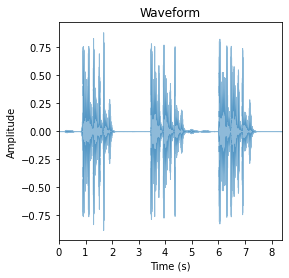

In [8]:
sig, sr = librosa.load('C:/Users/admin/corona_contest/public_dataset/00a4e142-2ae1-401e-8319-837e512b1281.wav', sr=16000)

plt.figure(figsize=(4,4))
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [29]:
# test
file_name = '../public_dataset/00eead73-a2c2-480d-b2ee-d79b1a526871.wav'
write_name = '../cut_wave/00eead73-a2c2-480d-b2ee-d79b1a526871_exam.wav'
cutting_wave(file_name, write_name)
model = load_model('../model/model_exam.h5')
image = classify_cough(write_name, model)[0]

AttributeError: module 'librosa' has no attribute 'output'